building model
model built
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_TimeLimit                               3600
Tried aggregator 3 times.
MIP Presolve eliminated 232475 rows and 139825 columns.
MIP Presolve modified 6000 coefficients.
Aggregator did 500 substitutions.
Reduced MIP has 27325 rows, 114750 columns, and 518800 nonzeros.
Reduced MIP has 112575 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 8.52 sec. (923.11 ticks)
Probing time = 0.11 sec. (52.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve added 300 rows and 0 columns.
MIP Presolve modified 6700 coefficients.
Reduced MIP has 27625 rows, 114750 columns, and 519400 nonzeros.
Reduced MIP has 112575 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 1.91 sec. (352.20 ticks)
Probing time = 0.08 sec. (48.12 ticks)
Clique table members: 307610.
MIP emphasi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[(0, 101)], [(0, 101)], [(0, 13), (13, 17), (17, 18), (18, 19), (19, 15), (15, 16), (16, 14), (14, 12), (12, 101)], [(0, 101)], [(0, 101)], [(0, 101)], [(0, 67), (67, 65), (65, 63), (63, 62), (62, 74), (74, 72), (72, 61), (61, 64), (64, 68), (68, 66), (66, 69), (69, 101)], [(0, 101)], [(0, 101)], [(0, 57), (57, 55), (55, 54), (54, 53), (53, 56), (56, 58), (58, 60), (60, 59), (59, 101)], [(0, 43), (43, 42), (42, 41), (41, 40), (40, 44), (44, 46), (46, 45), (45, 48), (48, 51), (51, 50), (50, 52), (52, 49), (49, 47), (47, 101)], [(0, 81), (81, 78), (78, 76), (76, 71), (71, 70), (70, 73), (73, 77), (77, 79), (79, 80), (80, 101)], [(0, 101)], [(0, 5), (5, 3), (3, 7), (7, 8), (8, 10), (10, 11), (11, 9), (9, 6), (6, 4), (4, 2), (2, 1), (1, 75), (75, 101)], [(0, 101)], [(0, 98), (98, 96), (96, 95), (95, 94), (94, 92), (92, 93), (93, 97), (97, 100), (100, 99), (99, 101)], [(0, 101)], [(0, 32), (32, 33), (33, 31), (31, 35), (35, 37), (37, 38), (38, 39), (39, 36), (36, 34), (34, 101)], [(0, 90),

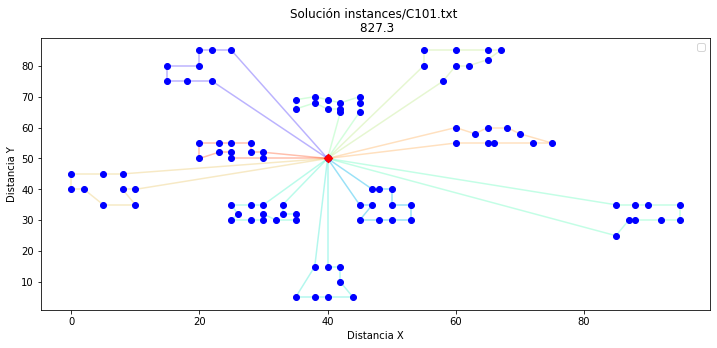

In [10]:
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import sys

class Instancia():
    def __init__(self,file_path, include_n_1 = False, num_nodos = None):
        self.file_path = file_path
        file_head = []
        cols_head = []
        instance_data = []
        with open(file_path) as f:
            file = f.readlines()
            file_name = file[0]
            self.vehicle_number = int(file[4].replace("\n","").split("\t")[0].split(" ")[2])
            self.vehicle_capacity = int(file[4].replace("\n","").split("\t")[0].split(" ")[-1])

            if num_nodos == None:
                for line in file[9:]:
                    line_data = [int(i) for i in line.split(" ") if i not in ["", "\n"]]
                    instance_data.append(line_data)
            if num_nodos!= None:
                for line in file[9:10+num_nodos]:
                    line_data = [int(i) for i in line.split(" ") if i not in ["", "\n"]]
                    instance_data.append(line_data)

            if include_n_1 == True:
                # Include n + 1
                n_1 = instance_data[0].copy()
                n_1[0] = len(instance_data)
                instance_data.append(n_1)

        instance_data = np.array(instance_data).astype(int)
        self.cust_no = instance_data[:,0]
        self.coord_x = instance_data[:,1]
        self.coord_y = instance_data[:,2]
        self.demand = instance_data[:,3]
        self.ready_time = instance_data[:,4]
        self.due_date = instance_data[:,5]
        self.service_time = instance_data[:,6]

        # Mathematical model data
        self.V = list(self.cust_no) # All nodes
        if include_n_1 == True:
            self.N = list(self.cust_no[1:-1]) # V\{0, n + 1}            
        else:
            self.N = list(self.cust_no[1:]) # V\{0}    

        self.K = [i for i in range(self.vehicle_number)] # All vehicles
        self.A = [(i,j) for i in self.V for j in self.V if i not in [j,self.V[-1]] if j!=0]

        # Toth y Vigo
        # self.c = {(i,j): np.hypot(self.coord_x[i] - self.coord_x[j] , self.coord_y[i] - self.coord_y[j]) for i,j in self.A}
        self.c = {(i,j): int(10*np.sqrt( (self.coord_x[i] - self.coord_x[j] )**2 + (self.coord_y[i] - self.coord_y[j])**2))/10 for i,j in self.A}
        # Solomon
        # self.c = {(i,j): np.round(np.hypot(self.coord_x[i] - self.coord_x[j] , self.coord_y[i] - self.coord_y[j]),1) for i in self.V for j in self.V if i!=j}
        self.a = list(self.ready_time.copy())
        self.b = list(self.due_date.copy())
        self.s = list(self.service_time.copy())
        self.Q = self.vehicle_capacity
        self.q = list(self.demand.copy())
        self.M = {(i,j): np.max(self.b[i]+self.s[i]+self.c[i,j]-self.a[j],0) for i,j in self.A}


class Modelo():
    def __init__(self):
        self.name = "VRPTW1"

    def build(self,ins):
        # Model
        # Model is VRPTW1 from Ch.5 Toth&Vigo, 2014
        self.mdl = Model(self.name)

        # Decision Variables
        self.x = self.mdl.binary_var_dict([(i,j,k) for i,j in ins.A for k in ins.K], name='x')
        self.T = self.mdl.continuous_var_dict([(i,k) for i in ins.V for k in ins.K],name='T')

        # Constraint 1
        self.mdl.minimize(self.mdl.sum(self.x[(i,j,k)]*ins.c[(i,j)] for i,j,k in [(i,j,k) for i,j in ins.A for k in ins.K]))
        # Constraint 2
        self.mdl.add_constraints(self.mdl.sum(self.x[(i,j,k)] for j in ins.V if j not in [0,i] for k in ins.K)==1 for i in ins.N)
        # Constraint 3
        self.mdl.add_constraints(self.mdl.sum(self.x[0,j,k] for j in ins.V if j!=0)==1 for k in ins.K)
        # Constraint 4        
        self.mdl.add_constraints(self.mdl.sum(self.x[(i,j,k)] for i in ins.V if i not in [j,ins.V[-1]]) == self.mdl.sum(self.x[j,i,k] for i in ins.V if i not in [j,0]) for j in ins.N for k in ins.K)
        # Constraint 5        
        self.mdl.add_constraints(self.mdl.sum(self.x[i,ins.V[-1],k] for i in ins.V if i!=ins.V[-1]) == 1 for k in ins.K)
        # Constraint 6        
        self.mdl.add_constraints(self.T[i,k] + ins.c[i,j] + ins.s[i] -ins.M[i,j]*(1 - self.x[(i,j,k)]) <= self.T[j,k] for i,j in ins.A for k in ins.K)
        # Constraint 7        
        self.mdl.add_constraints(self.T[i,k] >= ins.a[i] for i in ins.V for k in ins.K )
        # Constraint 8        
        self.mdl.add_constraints(self.T[i,k] <= ins.b[i] for i in ins.V for k in ins.K )
        # Constraint 9       
        self.mdl.add_constraints((self.mdl.sum(ins.q[i]*(self.mdl.sum(self.x[(i,j,k)] for j in ins.V if j not in [0,i])) for i in ins.N) <= ins.Q) for k in ins.K)

        # print(self.mdl.pprint_as_string())         
        self.mdl.parameters.timelimit=3600
        self.mdl.context.cplex_parameters.threads = 1
        self.mdl.export_as_lp("model_nico.lp")


    def solve(self):
        solution = self.mdl.solve(log_output=True)

        if solution:
            print("Obj: ",self.mdl.objective_value)
            self.mdl.report()
            
        else: 
            print("model has no solution...")

    def export_sol(self,ins):
        print(self.mdl.solution)

    def graficar_solucion(self,ins):
        rutas = []
        truck = []
        print(len(ins.V) - 1)
        for k in ins.K:
            for i in ins.V:
                if i !=0 and self.x[0,i,k].solution_value >0.9:
                    aux = [0,i]
                    while i != 0 and i != (len(ins.V) - 1):
                        j = i
                        for h in ins.V:
                            try:
                                if j !=h and self.x[j,h,k].solution_value > 0.9:
                                    aux.append(h)
                                    i = h
                            except:
                                pass    
                    rutas.append(aux)
                    truck.append(k)


        caminos_por_truck = []
        for i in truck:
            tuplas = []
            for j in range(len(rutas[i])):
                try:
                    tuplas.append((rutas[i][j],rutas[i][j + 1]))
                except:
                    pass
            caminos_por_truck.append(tuplas)
        print(caminos_por_truck)
        plt.figure(figsize = (12,5))
        plt.scatter(ins.coord_x,ins.coord_y, color = "blue")

        # DC
        plt.scatter(ins.coord_x[0],ins.coord_y[0], color = "red", marker = "D")


        color = iter(cm.rainbow(np.linspace(0, 1, ins.vehicle_number)))
        for v in truck:
            c = next(color)
            for i,j in caminos_por_truck[v]:
                plt.plot([ins.coord_x[i],ins.coord_x[j]],[ins.coord_y[i],ins.coord_y[j]], alpha=0.4, zorder=0, c = c)

        plt.xlabel("Distancia X")
        plt.ylabel("Distancia Y")
        plt.title("Solución {} \n {}".format(ins.file_path,self.mdl.objective_value))
        plt.legend()
        plt.show()




if __name__=="__main__":
    # Ejemplo de entrada
    # python main.py C101 10
    ins_name = "C101"
    num_nodos = 100    
    ins = Instancia("instances/{}.txt".format(ins_name),num_nodos=num_nodos, include_n_1=True) # FALSE FOR SOLOMON
    model = Modelo()
    print("building model")
    model.build(ins)
    # model.buildSolomon(ins)
    # print(ins.V)
    # print(ins.N)
    print("model built")
    model.solve()
    model.graficar_solucion(ins)


# Mejorar el origen de los indices, para no generar el objeto iterador cada vez
 